This notebook iterates over the run_sampler module five times to achieve a more accurate result. Each iteration has 30k steps, saves the chain every 30k steps, and plots the cornerplots for each batch. The goal here is to run the Orbitize! MCMC algorithm through our test data represending well-constrainted orbits. Next, we'll test the OFTI algorithm with orbits with less constraint.

In [1]:
import numpy as np
import sampler
import driver
import kepler
import system
import results
import multiprocessing as mp
import matplotlib.pyplot as plt
from numpy import loadtxt
import pandas as pd
import pickle
from matplotlib.backends.backend_pdf import PdfPages
import corner

In [2]:
params_list = pd.read_csv('/Users/rtejada/Desktop/test_params.csv',header=None,names=['m0','m1','P','ecc','argp',
                                                                                     'lan','inc','tperi','plx',
                                                                                     'gamma','sigma'])
params_list

,m0,m1,P,ecc,argp,lan,inc,tperi,plx,gamma,sigma
0,2.732812,0.296382,5723.547292,0.181849,4.878873,1.049311,0.702022,500.0,60.804643,66.415148,16.497966
1,1.910946,0.250833,6863.710697,0.809880,4.617912,0.423327,0.215450,500.0,46.896846,14.391493,12.378026
2,1.968237,0.089138,673.974271,0.131954,1.815709,1.398987,0.583262,500.0,80.677309,77.534799,17.544266
3,1.474015,0.016697,1098.835142,0.493135,0.054974,4.474184,1.329829,500.0,92.194087,26.168264,4.383070
4,2.775147,0.103769,2464.492220,0.232713,3.325733,0.345529,0.649586,500.0,93.300829,29.514289,17.693520


In [3]:
def tau0(Tp,ref_epoch,P):
    return (Tp - ref_epoch)/P

def p2sma(P,m0,m1):
    return ((P/365.25)**2*(m0+m1))**(1/3)

In [4]:
tau1 = tau0(params_list.values[1][7],0.0,params_list.values[1][2])
sma1 = p2sma(params_list.values[1][2],params_list.values[1][0],params_list.values[1][1])

tau2 = tau0(params_list.values[2][7],0.0,params_list.values[2][2])
sma2 = p2sma(params_list.values[2][2],params_list.values[2][0],params_list.values[1][1])

print(tau2)
print(sma2)

0.7418680829181203
1.9622712848187405


In [5]:
# MCMC parameters
num_temps = 15
num_walkers = 50
num_threads = mp.cpu_count() # or a different number if you prefer

myDriver = driver.Driver('/Users/rtejada/orbitize/tests/testdata2.csv', # path to data file
                                  sampler_str='MCMC', # name of algorithm for orbit-fitting
                                  num_secondary_bodies=1, # number of secondary bodies in system
                                  system_mass=2.0, # total system mass [M_sun]
                                  plx=81, # total parallax of system [mas]
                                  mass_err=0.05, # mass error [M_sun]
                                  plx_err=1.0, # parallax error [mas]
                                  system_kwargs = {'fit_secondary_mass':True,
                                  'tau_ref_epoch':0, 'gamma_bounds':(-100, 200), 'jitter_bounds':(1e-3, 50)},
                                  mcmc_kwargs={'num_temps': num_temps, 'num_walkers': num_walkers,
                                  'num_threads': num_threads})

total_orbits = 100000 # number of steps x number of walkers (at lowest temperature)
burn_steps = 1000 # steps to burn in per walker
thin = 10# only save every 2nd step

In [ ]:
path = '/Users/rtejada/Desktop/orbitize_mcmc/'
for i in range(5):
    #running the sampler:
    myDriver.sampler.run_sampler(total_orbits, burn_steps=0, thin=thin)
    chain = myDriver.sampler.chain
    print(np.shape(chain))
    #saving each sampler chainL
    pkl_file = open(path + 'testdata2_mcmcchains_run%1d.txt' % i,'wb')
    pickle.dump(chain,pkl_file)
    
    #plotting and saving corner plots per each 30k steps:
    corner_plot_fig = myDriver.sampler.results.plot_corner(show_titles=True,
                                     quantiles=[0.16,0.5,0.84]) # Creates a corner plot and returns Figure object
    corner_plot_fig.savefig(path + 'testdata2_cornerplot%1d.pdf' % i)
    
    for j in range(15):
        with PdfPages(path+'walkers_testdata2_mcmc%1d_temps%1d.pdf' % (i,j)) as pdf:
            shape = np.shape(chain)
            num_steps = shape[2]
            num_params = shape[3]
            num_walkers = shape[1]
            for p in range(num_params):
                pname = param_names[p]
                fig = plt.figure(figsize = (8,5))
                for x in range(num_walkers):
                    plt.plot(range(num_steps),myDriver.sampler.chain[j,x,:,p],alpha=0.7,linewidth=2) #makes trend plot trend
                    #plt.axhline(params_list.loc[p],ls='--',c='k')
                plt.ylabel(pname)
                plt.xlabel('steps')
                plt.minorticks_on()
                pdf.savefig()
                #plt.show()
                plt.close()
                
param_names = ['sma','e','i','$\omega$','$\Omega$','$\\tau$','$\pi$','$\gamma$','$\sigma$','M1','M0']
flatchain = np.reshape(chain[0],(-1,11))
corner_fig = corner.corner(flatchain,labels = param_names,quantiles=[0.16,0.5,0.84],
                          show_titles=True,range=np.ones(len(param_names))*0.99,title_kwargs={"fontsize": 17})
corner_fig.savefig(path + 'testdata2_flatchain_cornerplot3.pdf')

Burn in complete


/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.si

In [41]:
flatchain = np.reshape(chain[0],(-1,11))

In [42]:
np.shape(flatchain)

(10000, 11)

In [47]:
param_names = ['sma','e','i','$\omega$','$\Omega$','$\\tau$','$\pi$','$\gamma$','$\sigma$','M1','M0']

In [48]:
print(param_names)

['sma', 'e', 'i', '$\\omega$', '$\\Omega$', '$\\tau$', '$\\pi$', '$\\gamma$', '$\\sigma$', 'M1', 'M0']


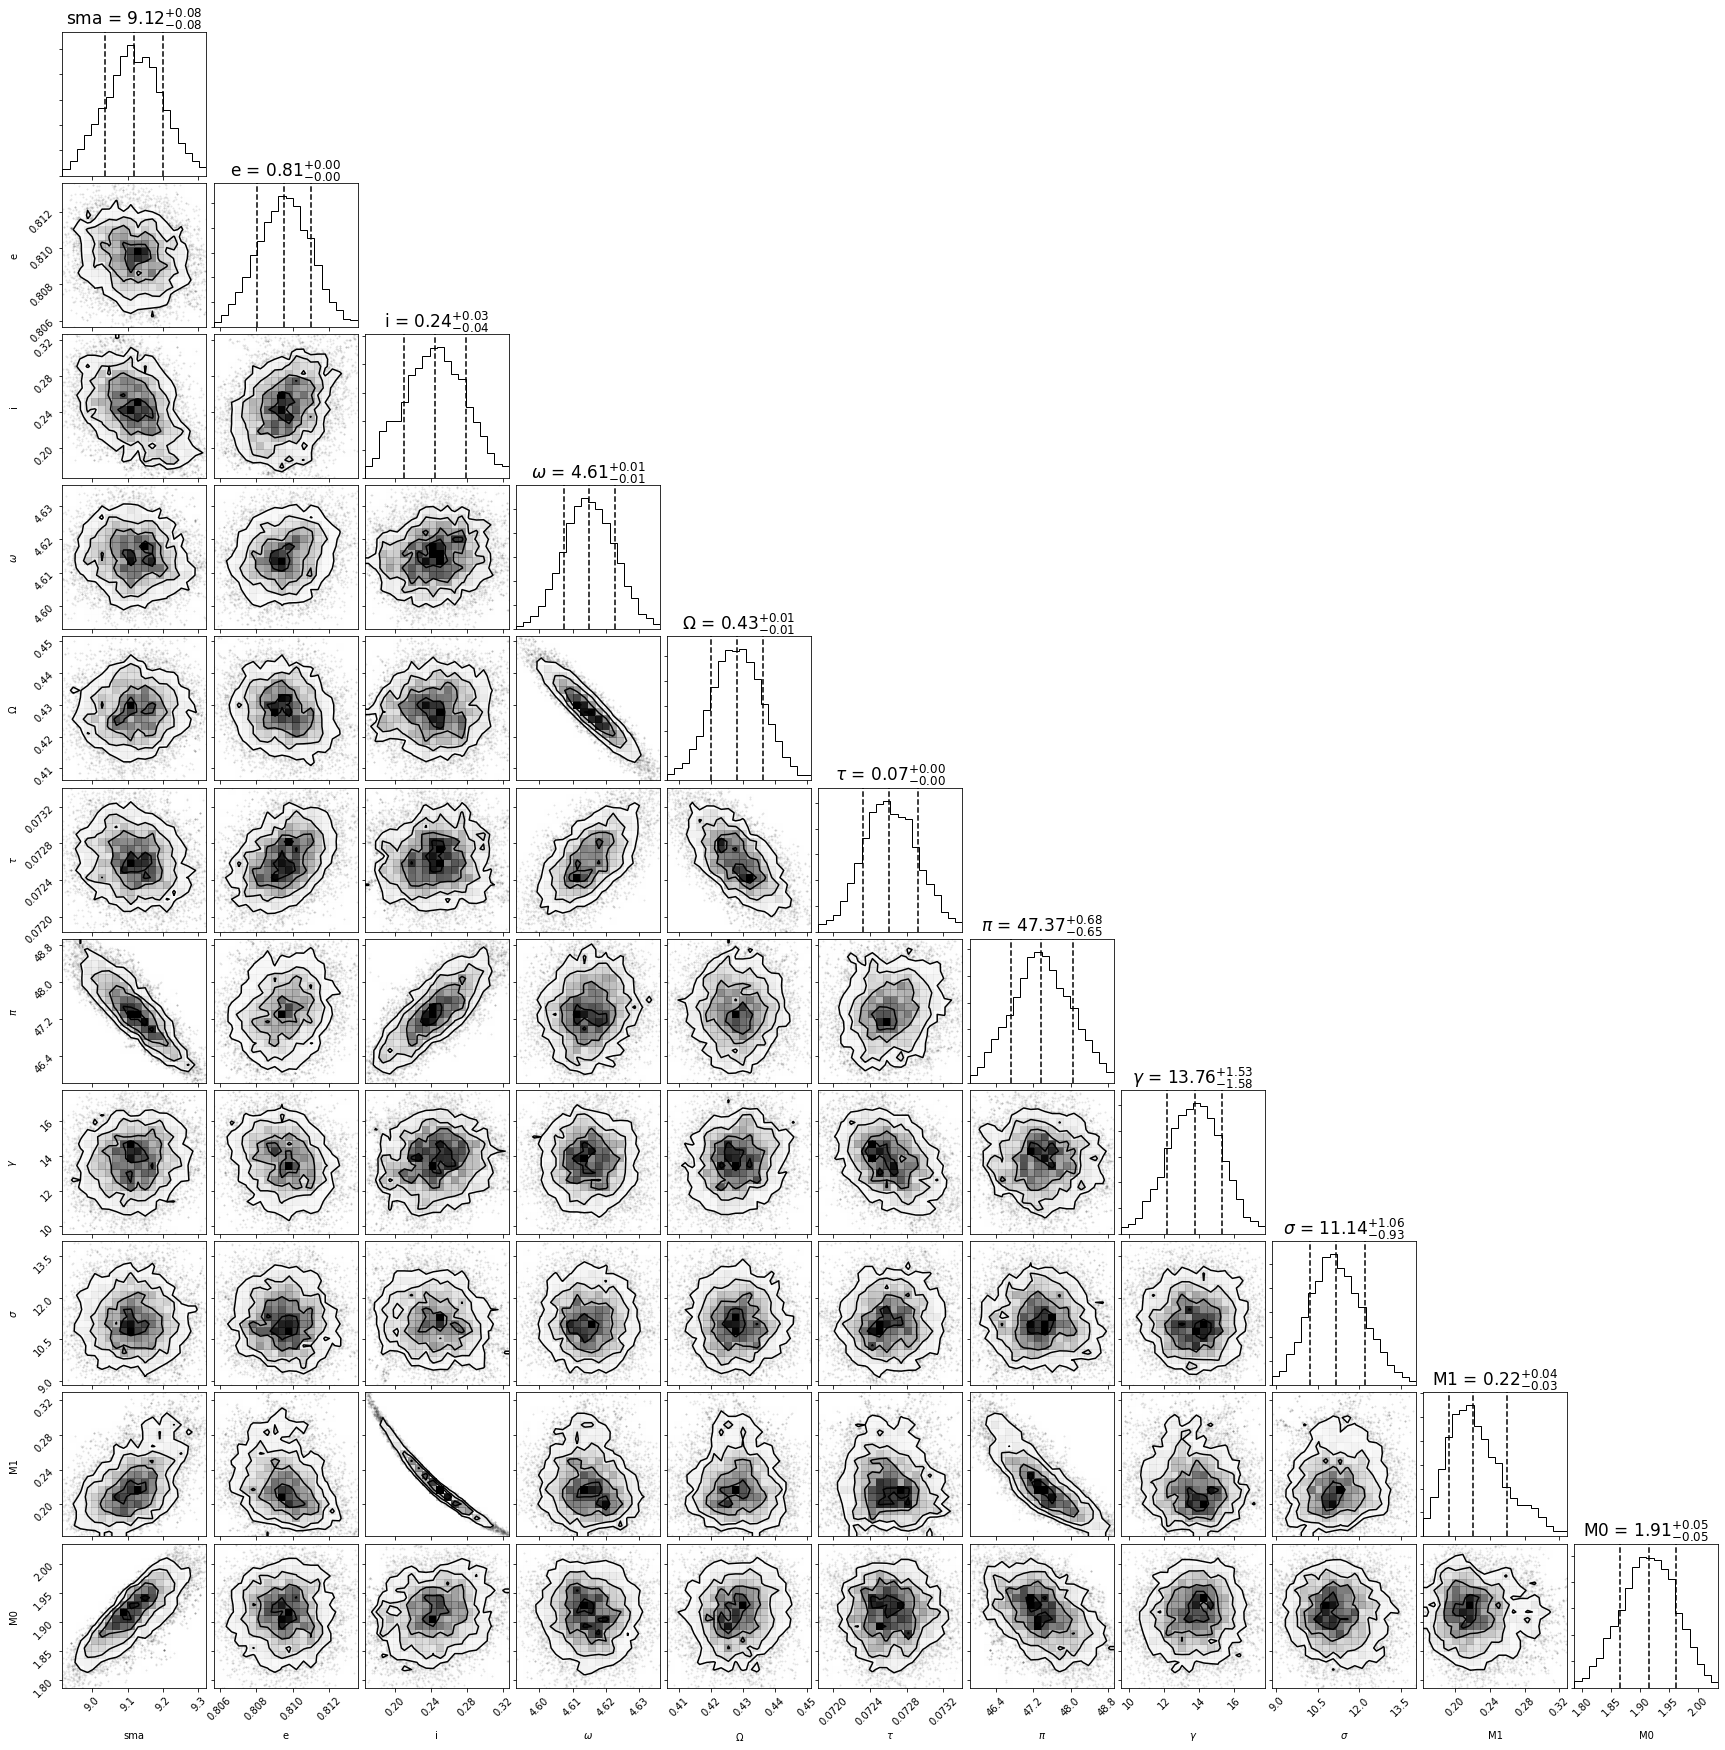

In [52]:
corner_fig = corner.corner(flatchain,labels = param_names,quantiles=[0.16,0.5,0.84],
                          show_titles=True,range=np.ones(len(param_names))*0.99,title_kwargs={"fontsize": 17})
corner_fig.savefig(path + 'testdata1_flatchain_cornerplot3.pdf')

In [19]:
np.shape(myDriver.sampler.results.post[:,0])

(40000,)

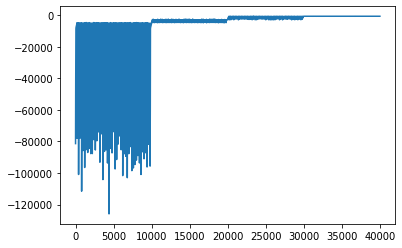

In [11]:
plt.plot(range(40000),myDriver.sampler.results.lnlike)

In [12]:
for i in range(15):
    with PdfPages(path+'walkers_testdata0_temps%1d.pdf' % i) as pdf:
        shape = np.shape(chain)
        num_steps = shape[2]
        num_params = shape[3]
        num_walkers = shape[1]
        for p in range(num_params):
            pname = param_names[p]
            fig = plt.figure(figsize = (8,5))
            for x in range(num_walkers):
                plt.plot(range(num_steps),myDriver.sampler.chain[i,x,:,p],alpha=0.7,linewidth=2) #makes trend plot trend
                #plt.axhline(params_list.loc[p],ls='--',c='k')
            plt.ylabel(pname)
            plt.xlabel('steps')
            plt.minorticks_on()
            pdf.savefig()
            #plt.show()
            plt.close()